### Project_m1

import libraries

In [9]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import re
import os
import duckdb
from shapely.geometry import Point
import geopandas as gpd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

Gardens

In [10]:
%%time
def adquisition_gardens(api):
    response = requests.get(api)
    results_api = response.json()
    return results_api

CPU times: total: 0 ns
Wall time: 0 ns


Bicimad

In [11]:
%%time
def adquisition_db_bicimad(datab):
    db_bicimad = duckdb.connect(datab)
    df_bicimad = db_bicimad.sql('select * from bicimad_stations').df()
    return df_bicimad

CPU times: total: 0 ns
Wall time: 0 ns


---

Wrangling

In [12]:
%%time
def wrangling_garden(result_api):
    result_select = result_api['@graph']
    df_garden = pd.DataFrame(result_select)
    df_garden_location = df_garden["location"].apply(pd.Series)
    df_garden_address = df_garden["address"].apply(pd.Series)
    df_garden_type = df_garden["@type"].str.replace('https://datos.madrid.es/egob/kos/entidadesYorganismos/', '').fillna("ParquesJardines")
    alls_df_garden = pd.concat([df_garden[['title']], df_garden_location, df_garden_address, df_garden_type], axis = 1)
    df_final_garden = alls_df_garden[['title', '@type', 'locality', 'postal-code', 'street-address', 'latitude', 'longitude']]
    df_final_garden.loc[:, '@type'] = 'Parques Jardines'
    return df_final_garden

CPU times: total: 0 ns
Wall time: 0 ns


In [13]:
%%time
def wrangling_bicimad(df_bicimad):
    df_bicimad[['longitude', 'latitude']] = df_bicimad["geometry.coordinates"].apply(lambda x: pd.Series(str(x).replace('[','').replace(']','').split(",")))
    df_bicimad['index'] = df_bicimad.index
    df_bicimad = df_bicimad[['name', 'address', 'latitude', 'longitude','index']]
    return df_bicimad

CPU times: total: 0 ns
Wall time: 0 ns


In [14]:
%%time
def wrangcoor(coor):
    coor = coor.astype(str)
    coor = coor.applymap(lambda x: remove_non_numeric(x))
    coor = coor.astype(float)
    coorm = coor.min(axis=1)
    coorm = coorm.to_dict()
    coor = coor.to_dict()
    dict_ms = {}
    for keys1, values1 in coor.items():
        for key_a, value_a in values1.items():
            for key_min, value_min in coorm.items():
                if value_a == value_min:
                    dict_ms[key_min] = (value_min, keys1)
    coor = dict(sorted(dict_ms.items()))        
    coor = pd.DataFrame.from_dict(coor, orient='index')        
    coor = coor.rename(columns={1: "index_station"})     
    return coor

CPU times: total: 0 ns
Wall time: 0 ns


---

Analisys

Modules

In [15]:
def to_mercator(lat, long):
    # transform latitude/longitude data in degrees to pseudo-mercator coordinates in metres
    c = gpd.GeoSeries([Point(lat, long)], crs=4326)
    c = c.to_crs(3857)
    return c

def distance_meters(lat_start, long_start, lat_finish, long_finish):
    # return the distance in metres between to latitude/longitude pair point in degrees (i.e.: 40.392436 / -3.6994487)
    start = to_mercator(lat_start, long_start)
    finish = to_mercator(lat_finish, long_finish)
    return start.distance(finish)

Own modules

In [16]:
%%time
def calculate_distances(df_place, df_station):
    distance_of_alls = []
    for index, row in df_place.iterrows():
        distance_one_station = []
        distance_of_alls.append(distance_one_station)
        for index, j in df_station.iterrows():
            distance_one_station.append(distance_meters(float(row['latitude']), float(row['longitude']), float(j['latitude']), float(j['longitude'])))
    df_coordinates = pd.DataFrame(distance_of_alls)
    return df_coordinates

CPU times: total: 0 ns
Wall time: 0 ns


In [17]:
%%time
def remove_non_numeric(s):
    return re.sub('[^0-9\.]+', '', s)

CPU times: total: 0 ns
Wall time: 0 ns


In [18]:
%%time
def min_stations(coor, df_bicimad):
    list_min_station_names = {}
    count = 0
    for index, row1 in coor.iterrows():
        for index, row2 in df_bicimad.iterrows():
            if row1['index_station'] == row2['index']:
                list_min_station_names[count]= (row2['name'], row2['address'])
                count = count +1
    df_min_station_names = pd.DataFrame(list_min_station_names)
    df_min_station_names = df_min_station_names.transpose()
    df_min_station_names1 = df_min_station_names.rename(columns={0: "name", 1:'address_station'})
    df_min_station_names_split = df_min_station_names1['name'].apply(lambda x: pd.Series(str(x).split('-')))
    df_min_station_names2 = df_min_station_names_split.rename(columns={0: "numberof", 1:'name_stn', 2:'null'})
    df_min_station_names = pd.concat([df_min_station_names2, df_min_station_names1], axis = 1)
    return df_min_station_names

CPU times: total: 0 ns
Wall time: 0 ns


In [19]:
def join_all(places, stations, distances):
    df_final = pd.concat([places, stations, distances], axis=1)
    df_final = df_final[['title', '@type', 'street-address', 'name_stn', 'address_station']]
    df_final = df_final.rename(columns={'title': 'Place of interest', '@type': 'Type of place', 'street-address': 'Place address', 'name_stn': 'BiciMAD station', 'address_station': 'Station location'})
    return df_final

---

Reporting

In [20]:
'''def result(dff):
        dff.to_csv('./data/gardens.csv')
        fig, ax =plt.subplots(figsize=(2.5,0.5))
        ax.axis('tight')
        ax.axis('off')
        the_table = ax.table(cellText=dff.values,colLabels=dff.columns,loc='center')
        pp = PdfPages("gardens.pdf")
        pp.savefig(fig, bbox_inches= None)
        pp.close()'''

'def result(dff):\n        dff.to_csv(\'./data/gardens.csv\')\n        fig, ax =plt.subplots(figsize=(2.5,0.5))\n        ax.axis(\'tight\')\n        ax.axis(\'off\')\n        the_table = ax.table(cellText=dff.values,colLabels=dff.columns,loc=\'center\')\n        pp = PdfPages("gardens.pdf")\n        pp.savefig(fig, bbox_inches= None)\n        pp.close()'

In [21]:
def result(dff):
        dff = dff.set_index("Place of interest")
        dff = dff.loc['Jardines de El Buen Retiro']
        dff = pd.DataFrame(dff)
        fig, ax =plt.subplots(figsize=(12,4))
        ax.axis('tight')
        ax.axis('off')
        the_table = ax.table(cellText=dff.values,colLabels=dff.columns,loc='center')
        pp = PdfPages("gardens.pdf")
        pp.savefig(fig, bbox_inches='tight')
        pp.close()

---

# Test

In [22]:
%%time
api_gardens = 'https://datos.madrid.es/egob/catalogo/200761-0-parques-jardines.json'

CPU times: total: 0 ns
Wall time: 0 ns


In [23]:
%%time
result_gardens = adquisition_gardens(api_gardens)

CPU times: total: 281 ms
Wall time: 1.59 s


In [24]:
%%time
databicimad = 'bicimad.db'

CPU times: total: 0 ns
Wall time: 0 ns


In [25]:
%%time
result_bicimad = adquisition_db_bicimad(databicimad)

CPU times: total: 0 ns
Wall time: 61.8 ms


In [26]:
%%time
gardens_data = wrangling_garden(result_gardens)
gardens_data

CPU times: total: 109 ms
Wall time: 158 ms


title             @type   
0                            Jardines Gregorio Ordóñez  Parques Jardines  \
1                     Jardines San Francisco el Grande  Parques Jardines   
2                           Jardines de Andrés Saborit  Parques Jardines   
3                           Jardines de El Buen Retiro  Parques Jardines   
4                           Jardines de Gloria Fuertes  Parques Jardines   
5                  Jardines de José Luis Jiménez Manso  Parques Jardines   
6                                    Jardines de Perón  Parques Jardines   
7                                 Jardines de Sabatini  Parques Jardines   
8                             Jardines de San Fernando  Parques Jardines   
9                     Jardines de la Avenida de Brasil  Parques Jardines   
10                             Jardines de la Basílica  Parques Jardines   
11      Jardines de la Plaza Conde del Valle de Suchil  Parques Jardines   
12                    Jardines de la Plaza de Chamberí  Parques Jardines   
13                     Jardines de la Plaza de Olavide  Parques Jardines   
14   Jardines de la Plaza de Oriente, Lepanto y Cab...  Parques Jardines   
15           Jardines de la Plaza de la Villa de París  Parques Jardines   
16                                 Jardines de la Vega  Parques Jardines   
17      Jardines de la calle Teresita González Quevedo  Parques Jardines   
18                           Jardines de las Vistillas  Parques Jardines   
19                      Jardines del Arquitecto Ribera  Parques Jardines   
20                         Jardines del Descubrimiento  Parques Jardines   
21                         Jardines del Doctor Fleming  Parques Jardines   
22                    Jardines del Mundial. Castellana  Parques Jardines   
23                    Jardines del Príncipe de Anglona  Parques Jardines   
24                       Jardín Botánico de Pradolongo  Parques Jardines   
25             Jardín Concejal Alejandro Muñoz Revenga  Parques Jardines   
26                           Jardín Doña Concha Piquer  Parques Jardines   
27                          Jardín Fachada Pirámides I  Parques Jardines   
28                           Jardín Glorieta de Azorín  Parques Jardines   
29                                       Jardín Jazmín  Parques Jardines   
30                             Jardín Palacio O'Reilly  Parques Jardines   
31                          Jardín de Embajadores M-30  Parques Jardines   
32                                     Jardín de Larra  Parques Jardines   
33                       Jardín de la Colonia Congosto  Parques Jardines   
34                          Jardín de las Bellas Artes  Parques Jardines   
35                   Jardín del Bulevar de Peña Gorbea  Parques Jardines   
36                          Jardín del Maestro Padilla  Parques Jardines   
37                          Jardín del Templo de Debod  Parques Jardines   
38              Jardín del paseo Federico García Lorca  Parques Jardines   
39                                    Jardín el Torero  Parques Jardines   
40    Jardín histórico El Capricho de la Alameda Osuna  Parques Jardines   
41    Palacio de Cristal de la Arganzuela: Invernadero  Parques Jardines   
42                    Parque Agustín Rodríguez Sahagún  Parques Jardines   
43                  Parque Alcalde Jesús Pérez Quijano  Parques Jardines   
44                                Parque Alfredo Kraus  Parques Jardines   
45                                      Parque Almansa  Parques Jardines   
46                                       Parque Aluche  Parques Jardines   
47                            Parque Aluche - Poblados  Parques Jardines   
48                                       Parque Alzola  Parques Jardines   
49                               Parque Antonio Pirala  Parques Jardines   
50                                  Parque Anunciación  Parques Jardines   
51                  Parque Arquitecto Antonio Palacios  Parques Jardines   
52                   

In [29]:
'''gardens_data_md = gardens_data['title']
gardens_data_md'''

0                              Jardines Gregorio Ordóñez
1                       Jardines San Francisco el Grande
2                             Jardines de Andrés Saborit
3                             Jardines de El Buen Retiro
4                             Jardines de Gloria Fuertes
5                    Jardines de José Luis Jiménez Manso
6                                      Jardines de Perón
7                                   Jardines de Sabatini
8                               Jardines de San Fernando
9                       Jardines de la Avenida de Brasil
10                               Jardines de la Basílica
11        Jardines de la Plaza Conde del Valle de Suchil
12                      Jardines de la Plaza de Chamberí
13                       Jardines de la Plaza de Olavide
14     Jardines de la Plaza de Oriente, Lepanto y Cab...
15             Jardines de la Plaza de la Villa de París
16                                   Jardines de la Vega
17        Jardines de la calle 

In [32]:
'''gardens_data_md = gardens_data_md.to_list()
gardens_data_md'''

['Jardines Gregorio Ordóñez',
 'Jardines San Francisco el Grande',
 'Jardines de Andrés Saborit',
 'Jardines de El Buen Retiro',
 'Jardines de Gloria Fuertes',
 'Jardines de José Luis Jiménez Manso',
 'Jardines de Perón',
 'Jardines de Sabatini',
 'Jardines de San Fernando',
 'Jardines de la Avenida de Brasil',
 'Jardines de la Basílica',
 'Jardines de la Plaza Conde del Valle de Suchil',
 'Jardines de la Plaza de Chamberí',
 'Jardines de la Plaza de Olavide',
 'Jardines de la Plaza de Oriente, Lepanto y Cabo Noval',
 'Jardines de la Plaza de la Villa de París',
 'Jardines de la Vega',
 'Jardines de la calle Teresita González Quevedo',
 'Jardines de las Vistillas',
 'Jardines del Arquitecto Ribera',
 'Jardines del Descubrimiento',
 'Jardines del Doctor Fleming',
 'Jardines del Mundial. Castellana',
 'Jardines del Príncipe de Anglona',
 'Jardín Botánico de Pradolongo',
 'Jardín Concejal Alejandro Muñoz Revenga',
 'Jardín Doña Concha Piquer',
 'Jardín Fachada Pirámides I',
 'Jardín Glori

In [46]:
'''fivecolumns = {}
count = 0
countk = 1
list_md = []
for i in gardens_data_md:
    list_md.append(i)
    count = count +1
    if count == 29:
        fivecolumns[countk]=(list_md)
        count=0
        countk = countk +1
        list_md = []
        
fivecolumns'''

{1: ['Jardines Gregorio Ordóñez',
  'Jardines San Francisco el Grande',
  'Jardines de Andrés Saborit',
  'Jardines de El Buen Retiro',
  'Jardines de Gloria Fuertes',
  'Jardines de José Luis Jiménez Manso',
  'Jardines de Perón',
  'Jardines de Sabatini',
  'Jardines de San Fernando',
  'Jardines de la Avenida de Brasil',
  'Jardines de la Basílica',
  'Jardines de la Plaza Conde del Valle de Suchil',
  'Jardines de la Plaza de Chamberí',
  'Jardines de la Plaza de Olavide',
  'Jardines de la Plaza de Oriente, Lepanto y Cabo Noval',
  'Jardines de la Plaza de la Villa de París',
  'Jardines de la Vega',
  'Jardines de la calle Teresita González Quevedo',
  'Jardines de las Vistillas',
  'Jardines del Arquitecto Ribera',
  'Jardines del Descubrimiento',
  'Jardines del Doctor Fleming',
  'Jardines del Mundial. Castellana',
  'Jardines del Príncipe de Anglona',
  'Jardín Botánico de Pradolongo',
  'Jardín Concejal Alejandro Muñoz Revenga',
  'Jardín Doña Concha Piquer',
  'Jardín Facha

In [47]:
#pd.DataFrame(fivecolumns)

1   
0                           Jardines Gregorio Ordóñez  \
1                    Jardines San Francisco el Grande   
2                          Jardines de Andrés Saborit   
3                          Jardines de El Buen Retiro   
4                          Jardines de Gloria Fuertes   
5                 Jardines de José Luis Jiménez Manso   
6                                   Jardines de Perón   
7                                Jardines de Sabatini   
8                            Jardines de San Fernando   
9                    Jardines de la Avenida de Brasil   
10                            Jardines de la Basílica   
11     Jardines de la Plaza Conde del Valle de Suchil   
12                   Jardines de la Plaza de Chamberí   
13                    Jardines de la Plaza de Olavide   
14  Jardines de la Plaza de Oriente, Lepanto y Cab...   
15          Jardines de la Plaza de la Villa de París   
16                                Jardines de la Vega   
17     Jardines de la calle Teresita González Quevedo   
18                          Jardines de las Vistillas   
19                     Jardines del Arquitecto Ribera   
20                        Jardines del Descubrimiento   
21                        Jardines del Doctor Fleming   
22                   Jardines del Mundial. Castellana   
23                   Jardines del Príncipe de Anglona   
24                      Jardín Botánico de Pradolongo   
25            Jardín Concejal Alejandro Muñoz Revenga   
26                          Jardín Doña Concha Piquer   
27                         Jardín Fachada Pirámides I   
28                          Jardín Glorieta de Azorín   

                                                   2   
0                                      Jardín Jazmín  \
1                            Jardín Palacio O'Reilly   
2                         Jardín de Embajadores M-30   
3                                    Jardín de Larra   
4                      Jardín de la Colonia Congosto   
5                         Jardín de las Bellas Artes   
6                  Jardín del Bulevar de Peña Gorbea   
7                         Jardín del Maestro Padilla   
8                         Jardín del Templo de Debod   
9             Jardín del paseo Federico García Lorca   
10                                  Jardín el Torero   
11  Jardín histórico El Capricho de la Alameda Osuna   
12  Palacio de Cristal de la Arganzuela: Invernadero   
13                  Parque Agustín Rodríguez Sahagún   
14                Parque Alcalde Jesús Pérez Quijano   
15                              Parque Alfredo Kraus   
16                                    Parque Almansa   
17                                     Parque Aluche   
18                          Parque Aluche - Poblados   
19                                     Parque Alzola   
20                             Parque Antonio Pirala   
21                                Parque Anunciación   
22                Parque Arquitecto Antonio Palacios   
23                           Parque Arroyo Fontarrón   
24                              Parque Arroyo Fresno   
25                             Parque Arroyo Pozuelo   
26                        Parque Arroyo de los Pinos   
27                        Parque Avenida de Portugal   
28                                     Parque Azorín   

                                         3   
0                  Parque Barrio Las Musas  \
1                            Parque Begoña   
2                      Parque Biosaludable   
3                Parque Campo de la Paloma   
4                          Parque Caramuel   
5                   Parque Cerro Almodóvar   
6                     Parque Cerro Peñabel   
7                 Parque Cerro del Tío Pío   
8                      Parque Cerro Águila   
9             Parque Ciudad de los Ángeles   
10                Parque Cuesta del Galbán   
11  Parque Cuña Verde de Vicálvaro. Zona A   
12  Parque Cuña Verde de Vicálvaro. Zona B   
13  Parque Cuña 

In [ ]:
    for keys1, values1 in coor.items():
        for key_a, value_a in values1.items():
            for key_min, value_min in coorm.items():
                if value_a == value_min:
                    dict_ms[key_min] = (value_min, keys1)

In [ ]:
    list_min_station_names = {}
    count = 0
    for index, row1 in coor.iterrows():
        for index, row2 in df_bicimad.iterrows():
            if row1['index_station'] == row2['index']:
                list_min_station_names[count]= (row2['name'], row2['address'])
                count = count +1

In [27]:
%%time
bicimad_data = wrangling_bicimad(result_bicimad)

CPU times: total: 15.6 ms
Wall time: 59.2 ms


In [28]:
%%time
distances_g_st = calculate_distances(gardens_data, bicimad_data)

CPU times: total: 10min 59s
Wall time: 12min 2s


In [21]:
%%time
distances_g_st

CPU times: total: 0 ns
Wall time: 0 ns


0                                 1     
0       0    3160.9304
dtype: float64   0    3133.481106
dtype: float64  \
1     0    1607.914611
dtype: float64   0    1634.115402
dtype: float64   
2     0    3235.127493
dtype: float64   0    3221.706617
dtype: float64   
3      0    1573.97183
dtype: float64   0    1546.689333
dtype: float64   
4     0    5762.394493
dtype: float64   0    5739.648206
dtype: float64   
5     0    4663.121842
dtype: float64   0    4639.298466
dtype: float64   
6     0    3993.981709
dtype: float64   0    3978.829257
dtype: float64   
7     0    1301.381241
dtype: float64   0    1324.033696
dtype: float64   
8     0    5007.160824
dtype: float64     0    4988.4525
dtype: float64   
9     0    4712.465113
dtype: float64   0    4696.608619
dtype: float64   
10    0    3609.765574
dtype: float64   0    3594.068604
dtype: float64   
11    0    1659.137313
dtype: float64   0    1656.934801
dtype: float64   
12    0    1804.084287
dtype: float64   0    1786.823443
dtype: float64   
13    0    1702.749415
dtype: float64   0    1690.166777
dtype: float64   
14    0    1234.165196
dtype: float64   0    1258.754043
dtype: float64   
15    0    1369.901169
dtype: float64   0    1344.286376
dtype: float64   
16    0    1542.241455
dtype: float64   0    1569.584051
dtype: float64   
17    0    4305.150902
dtype: float64   0    4291.071719
dtype: float64   
18    0    1480.624843
dtype: float64   0    1508.606851
dtype: float64   
19      0    1037.3621
dtype: float64   0    1022.505338
dtype: float64   
20     0    1705.28905
dtype: float64   0    1677.538256
dtype: float64   
21    0    4381.248554
dtype: float64    0    4362.67271
dtype: float64   
22    0    4228.531869
dtype: float64   0    4209.702815
dtype: float64   
23    0    1154.655817
dtype: float64   0    1182.687485
dtype: float64   
24    0    4974.535831
dtype: float64    0    4991.29033
dtype: float64   
25    0    2109.366199
dtype: float64   0    2114.512591
dtype: float64   
26    0    2232.404011
dtype: float64   0    2257.674443
dtype: float64   
27    0    2157.067537
dtype: float64   0    2181.127083
dtype: float64   
28    0    1622.618938
dtype: float64   0    1649.906875
dtype: float64   
29    0    8564.042621
dtype: float64   0    8540.787877
dtype: float64   
30      0    1164.5971
dtype: float64   0    1192.472811
dtype: float64   
31    0    4087.888706
dtype: float64   0    4086.627538
dtype: float64   
32    0    1226.632704
dtype: float64   0    1253.260577
dtype: float64   
33   0    10642.852174
dtype: float64  0    10625.655805
dtype: float64   
34    0    2732.906481
dtype: float64    0    2711.30329
dtype: float64   
35    0    4556.454759
dtype: float64   0    4540.314738
dtype: float64   
36    0    2595.393621
dtype: float64   0    2623.021472
dtype: float64   
37    0    1817.118087
dtype: float64   0    1835.754494
dtype: float64   
38    0    10082.81091
dtype: float64  0    10064.513968
dtype: float64   
39     0    2818.50629
dtype: float64   0    2833.381652
dtype: float64   
40   0    12082.269401
dtype: float64  0    12054.266418
dtype: float64   
41    0    2677.232125
dtype: float64   0    2684.775635
dtype: float64   
42    0    5906.102519
dtype: float64   0    5896.143255
dtype: float64   
43    0    8923.328382
dtype: float64    0    8899.68793
dtype: float64   
44    0    9189.480587
dtype: float64   0    9162.739139
dtype: float64   
45    0    3790.564619
dtype: float64   0    3789.030771
dtype: float64   
46     0    6896.72045
dtype: float64   0    6924.754768
dtype: float64   
47    0    7903.689377
dtype: float64   0    7931.682182
dtype: float64   
48    0    5725.138415
dtype: float64   0    5741.852254
dtype: float64   
49    0    4874.943156
dtype: float64   0    4847.174376
dtype: float64   
50    0    2959.476159
dtype: float64   0    2936.438614
dtype: float64   
51   0    10649.451307
dtype: float64   0    10621.86137
dtype: float64   
52    0    7739.800382
dtype: float64   0    7718.975983
dt

In [22]:
%%time
wrang_distances = wrangcoor(distances_g_st)

CPU times: total: 1.17 s
Wall time: 15.5 s


In [23]:
%%time
wrang_distances

CPU times: total: 0 ns
Wall time: 0 ns


0  index_station
0      126.921709            145
1      124.985614             45
2      173.253360            135
3       53.248708             60
4      255.108936            256
5      305.991986            220
6      283.866389            156
7      203.175765             30
8      241.273620            159
9      223.129243            158
10      38.492502            153
11     130.457813              3
12     288.052756            126
13     233.338277            126
14     176.703045             30
15     175.180437             10
16     231.610697            168
17     280.751813            156
18     142.753634            168
19      33.965862             54
20      87.571802             92
21     146.912794            255
22     283.859034            255
23     153.549236             35
24    2158.589087            215
25     294.388310            125
26     139.507242            171
27      76.340725            171
28     185.632512            169
29    2826.151752            251
30     167.317330             35
31     758.735067            237
32     120.103060             36
33    3746.439790            223
34      79.460680            141
35     249.404162            229
36     438.619742            225
37     139.556855            116
38    2992.051283            223
39     332.639770            224
40    5329.689523            217
41     124.436245            167
42    1084.407965            209
43    1371.143204            223
44    3221.046015            232
45     327.676039            258
46    3806.059004            226
47    4866.631733            226
48    2853.989675            215
49     290.601466            190
50      96.373787             72
51    3726.606452            217
52     647.968664            223
53    3432.314377            219
54    6287.006435            263
55    2553.889198            263
56     838.769410            218
57    1092.761548            228
58    3728.566565            217
59     343.173117            219
60    4852.158673            217
61    2148.386188            223
62     144.265595            226
63    2474.625316            226
64    2238.191123            241
65     656.373944            228
66    3614.189243            263
67    4040.697644            215
68    4318.508816            263
69    2119.015848            223
70    2210.355116            223
71    3213.215249            223
72    1246.146682            263
73    3201.865654            223
74     399.563682            191
75    1374.888746            256
76    4275.098697            215
77     147.979559            168
78    1902.593060            214
79     678.414480            182
80    2897.237936            229
81    2409.054624            229
82    1965.499357            223
83    4268.113248            226
84     362.644096            147
85    1210.376402            223
86    3700.955608            215
87    4666.413808            232
88    3343.880133            223
89     888.481170            253
90    6919.234937            226
91    3672.552764            256
92    4859.312874            215
93    4210.874076            232
94    3122.146050            232
95     321.097206            199
96    4198.407836            263
97     970.260366            182
98      64.000000            263
99    1631.679188            223
100   4290.328146            223
101    410.032815            171
102    318.270688            221
103    101.705885            181
104   2545.525137            215
105    733.296390            120
106   4331.273449            232
107    545.204442            219
108    511.501933            251
109   1241.306937            230
110    336.957546            162
111   2959.145279            226
112    854.861326            229
113    194.224903            175
114    470.955276            235
115   2267.324504            216
116   4061.071450            237
117   4106.987913            237
118    125.107076            118
119   2577.203176            217
120    213.277559      

In [24]:
%%time
min_to_station = min_stations(wrang_distances, bicimad_data)
min_to_station

CPU times: total: 3.06 s
Wall time: 3.26 s


numberof                    name_stn    null   
0       143             Diego de León 52     NaN  \
1        45             Puerta de Toledo     NaN   
2       133           Raimundo Fernández     NaN   
3        60    Plaza de la Independencia     NaN   
4       254                      Pío XII     NaN   
5       218             Camino Vinateros     NaN   
6       154                    Orense 36     NaN   
7        30                  San Quintín     NaN   
8       157               Castellana 164     NaN   
9       156        Sor Ángela de la Cruz     NaN   
10      151                    Orense 12     NaN   
11        3           Plaza Conde Suchil     NaN   
12      124               Manuel Silvela     NaN   
13      124               Manuel Silvela     NaN   
14       30                  San Quintín     NaN   
15       10       Marqués de la Ensenada     NaN   
16      166                   Segovia 26     NaN   
17      154                    Orense 36     NaN   
18      166                   Segovia 26     NaN   
19       54                      Barceló     NaN   
20       93               Plaza de Colón     NaN   
21      253               Doctor Fleming     NaN   
22      253               Doctor Fleming     NaN   
23       35             Plaza del Cordón     NaN   
24      213            Glorieta de Cádiz     NaN   
25      123              Guzmán el Bueno     NaN   
26      169                    Pirámides     NaN   
27      169                    Pirámides     NaN   
28      167                   Segovia 45     NaN   
29      249              Manuel Caldeiro     NaN   
30       35             Plaza del Cordón     NaN   
31      235              Embajadores 191     NaN   
32       36                Plaza Ramales     NaN   
33      221                      Pavones     NaN   
34      139      José Gutiérrez Abascal      NaN   
35      227                    Concordia     NaN   
36      223                 Ermita Santo     NaN   
37      115                       Ferraz     NaN   
38      221                      Pavones     NaN   
39      222                Antonio López     NaN   
40      215           Gutierre de Cetina     NaN   
41      165             Entrada Matadero     NaN   
42      207                      Remonta     NaN   
43      221                      Pavones     NaN   
44      230              Carlota O’Neill     NaN   
45      256               Reina Victoria     NaN   
46      224                     Caramuel     NaN   
47      224                     Caramuel     NaN   
48      213            Glorieta de Cádiz     NaN   
49      188             Puente de Ventas     NaN   
50       74         Puerta del Pacífico      NaN   
51      215           Gutierre de Cetina     NaN   
52      221                      Pavones     NaN   
53      217                   Pedro Rico     NaN   
54      261             Facultad Derecho     NaN   
55      261             Facultad Derecho     NaN   
56      216             Puerta del Ángel     NaN   
57      226              Sierra Toledana     NaN   
58      215           Gutierre de Cetina     NaN   
59      217                   Pedro Rico     NaN   
60      215           Gutierre de Cetina     NaN   
61      221                      Pavones     NaN   
62      224                     Caramuel     NaN   
63      224                     Caramuel     NaN   
64      239            Francos Rodríguez     NaN   
65      226              Sierra Toledana     NaN   
66      261             Facultad Derecho     NaN   
67      213            Glorieta de Cádiz     NaN   
68      261             Facultad Derecho     NaN   
69      221                      Pavones     NaN   
70      221                      Pavones     NaN   
71      221                      Pavones     NaN   
72      261             Facultad Derecho     NaN   
73      221                      Pavones     NaN   
74      189          Avenida Donostiarra     NaN   
75      254                      Pío XII     NaN   


In [25]:
%%time
df_gsd = join_all(gardens_data, bicimad_data, min_to_station)


CPU times: total: 0 ns
Wall time: 4.22 ms


In [26]:
df_gsd

Place of interest     Type of place   
0                            Jardines Gregorio Ordóñez  Parques Jardines  \
1                     Jardines San Francisco el Grande  Parques Jardines   
2                           Jardines de Andrés Saborit  Parques Jardines   
3                           Jardines de El Buen Retiro  Parques Jardines   
4                           Jardines de Gloria Fuertes  Parques Jardines   
5                  Jardines de José Luis Jiménez Manso  Parques Jardines   
6                                    Jardines de Perón  Parques Jardines   
7                                 Jardines de Sabatini  Parques Jardines   
8                             Jardines de San Fernando  Parques Jardines   
9                     Jardines de la Avenida de Brasil  Parques Jardines   
10                             Jardines de la Basílica  Parques Jardines   
11      Jardines de la Plaza Conde del Valle de Suchil  Parques Jardines   
12                    Jardines de la Plaza de Chamberí  Parques Jardines   
13                     Jardines de la Plaza de Olavide  Parques Jardines   
14   Jardines de la Plaza de Oriente, Lepanto y Cab...  Parques Jardines   
15           Jardines de la Plaza de la Villa de París  Parques Jardines   
16                                 Jardines de la Vega  Parques Jardines   
17      Jardines de la calle Teresita González Quevedo  Parques Jardines   
18                           Jardines de las Vistillas  Parques Jardines   
19                      Jardines del Arquitecto Ribera  Parques Jardines   
20                         Jardines del Descubrimiento  Parques Jardines   
21                         Jardines del Doctor Fleming  Parques Jardines   
22                    Jardines del Mundial. Castellana  Parques Jardines   
23                    Jardines del Príncipe de Anglona  Parques Jardines   
24                       Jardín Botánico de Pradolongo  Parques Jardines   
25             Jardín Concejal Alejandro Muñoz Revenga  Parques Jardines   
26                           Jardín Doña Concha Piquer  Parques Jardines   
27                          Jardín Fachada Pirámides I  Parques Jardines   
28                           Jardín Glorieta de Azorín  Parques Jardines   
29                                       Jardín Jazmín  Parques Jardines   
30                             Jardín Palacio O'Reilly  Parques Jardines   
31                          Jardín de Embajadores M-30  Parques Jardines   
32                                     Jardín de Larra  Parques Jardines   
33                       Jardín de la Colonia Congosto  Parques Jardines   
34                          Jardín de las Bellas Artes  Parques Jardines   
35                   Jardín del Bulevar de Peña Gorbea  Parques Jardines   
36                          Jardín del Maestro Padilla  Parques Jardines   
37                          Jardín del Templo de Debod  Parques Jardines   
38              Jardín del paseo Federico García Lorca  Parques Jardines   
39                                    Jardín el Torero  Parques Jardines   
40    Jardín histórico El Capricho de la Alameda Osuna  Parques Jardines   
41    Palacio de Cristal de la Arganzuela: Invernadero  Parques Jardines   
42                    Parque Agustín Rodríguez Sahagún  Parques Jardines   
43                  Parque Alcalde Jesús Pérez Quijano  Parques Jardines   
44                                Parque Alfredo Kraus  Parques Jardines   
45                                      Parque Almansa  Parques Jardines   
46                                       Parque Aluche  Parques Jardines   
47                            Parque Aluche - Poblados  Parques Jardines   
48                                       Parque Alzola  Parques Jardines   
49                               Parque Antonio Pirala  Parques Jardines   
50                                  Parque Anunciación  Parques Jardines   
51                  Parque Arquitecto Antonio Palacios  Parques Jardines   
52       

CPU times: total: 31.2 ms
Wall time: 140 ms


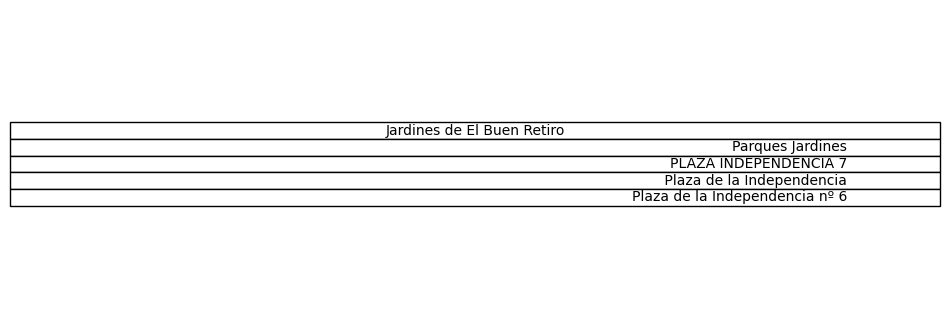

In [27]:
%%time
result(df_gsd)